In [ ]:
!pip install tensorflow opencv-python numpy matplotlib

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload dataset.zip
!unzip dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/no_stone/Normal- (1181).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1182).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1183).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1184).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1185).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1186).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (119).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1190).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1192).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1194).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1196).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1198).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (1199).jpg  
  inflating: /content/dataset/train/no_stone/Normal- (12).jpg  
  inflating: /content/datase

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Random rotation up to 20 degrees
    width_shift_range=0.2,   # Shift width by 20%
    height_shift_range=0.2,  # Shift height by 20%
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Flip horizontally
    fill_mode='nearest',     # Fill new pixels
    validation_split=0.2     # 20% for validation
)

# Test generator (no augmentation, just rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',    # Path to train folder
    target_size=(224, 224),      # Resize to 224x224
    color_mode='grayscale',      # Grayscale for CT/ultrasound (use 'rgb' if colored)
    batch_size=32,               # Images per batch
    class_mode='binary',         # Binary classification (stone vs. no_stone)
    subset='training'            # 80% for training
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation'          # 20% for validation
)

Found 4130 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test',     # Path to test folder
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

Found 1292 images belonging to 2 classes.


In [ ]:
import numpy as np

def convert_to_rgb(generator):
    for batch_x, batch_y in generator:
        batch_x_rgb = np.repeat(batch_x, 3, axis=-1)  # Convert (batch, 224, 224, 1) to (batch, 224, 224, 3)
        yield batch_x_rgb, batch_y

# Apply to all generators
train_generator_rgb = convert_to_rgb(train_generator)
validation_generator_rgb = convert_to_rgb(validation_generator)
test_generator_rgb = convert_to_rgb(test_generator)

Batch shape: (32, 224, 224, 3)
Labels: [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1.]


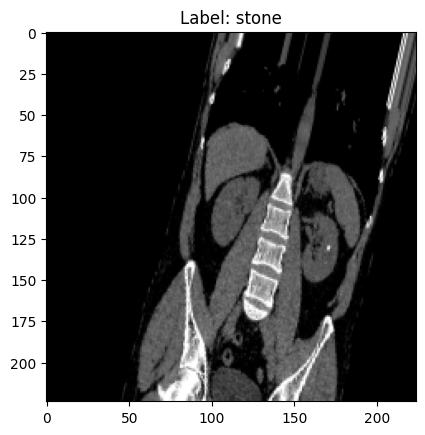

In [ ]:
# Get one batch
batch_x, batch_y = next(train_generator_rgb)
print("Batch shape:", batch_x.shape)  # Should be (32, 224, 224, 3)
print("Labels:", batch_y)             # 0s (no_stone) and 1s (stone)

# Visualize one image
import matplotlib.pyplot as plt
plt.imshow(batch_x[0])  # Display first image
plt.title(f"Label: {'stone' if batch_y[0] == 1 else 'no_stone'}")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)           # Reduce to a 1D vector
x = Dense(128, activation='relu')(x)      # Fully connected layer with 128 units
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',              # Adaptive optimizer
    loss='binary_crossentropy',    # Loss for binary classification
    metrics=['accuracy']           # Track accuracy during training
)

In [ ]:
# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Assuming this is already run, just a check
batch_x, batch_y = next(train_generator_rgb)
print("Train batch shape:", batch_x.shape)  # Should be (32, 224, 224, 3)
print("Train labels:", batch_y)

Train batch shape: (32, 224, 224, 3)
Train labels: [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 1.]


In [ ]:
# Train the model
history = model.fit(
    train_generator_rgb,                  # Training data
    validation_data=validation_generator_rgb,  # Validation data
    epochs=10,                            # Number of passes through the data
    steps_per_epoch=len(train_generator), # Batches per epoch
    validation_steps=len(validation_generator)  # Batches for validation
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8034 - loss: 0.4769 - val_accuracy: 0.7452 - val_loss: 0.5879
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9144 - loss: 0.2210 - val_accuracy: 0.7888 - val_loss: 0.4369
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9235 - loss: 0.1900 - val_accuracy: 0.8172 - val_loss: 0.4863
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9421 - loss: 0.1313 - val_accuracy: 0.8643 - val_loss: 0.3345
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9557 - loss: 0.1117 - val_accuracy: 0.8886 - val_loss: 0.2443
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9713 - loss: 0.0810 - val_accuracy: 0.8789 - val_loss: 0.2736
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9722 - loss: 0.0776 - val_accuracy: 0.8818 - val_loss: 0.2763
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9717 - loss: 0.0709 - val_accu

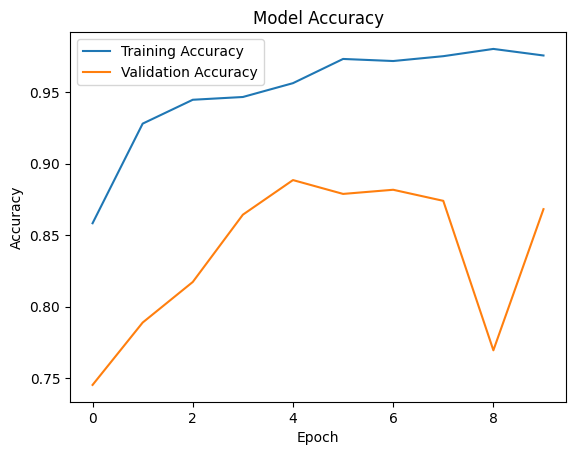

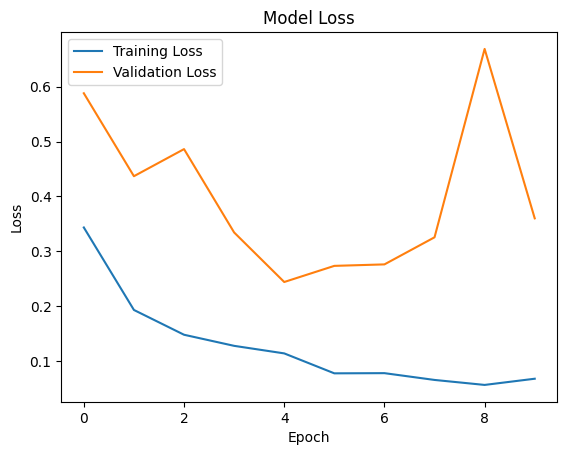

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Check test generator
batch_x, batch_y = next(test_generator_rgb)
print("Test batch shape:", batch_x.shape)  # Should be (32, 224, 224, 3)
print("Test labels:", batch_y)             # 0s (no_stone) and 1s (stone)

Test batch shape: (32, 224, 224, 3)
Test labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator_rgb, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 795ms/step - accuracy: 0.8921 - loss: 0.3344
Test Loss: 0.3088
Test Accuracy: 90.02%


In [ ]:
import numpy as np

# Predict on test data
predictions = model.predict(test_generator_rgb, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Threshold at 0.5

# Get true labels from generator
true_labels = []
for i in range(len(test_generator)):
    _, batch_y = next(test_generator_rgb)
    true_labels.extend(batch_y)
true_labels = np.array(true_labels[:len(predicted_classes)])  # Match lengths

print("Predicted classes:", predicted_classes)
print("True classes:", true_labels)

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step
Predicted classes: [0 1 0 ... 0 0 0]
True classes: [1. 0. 0. ... 0. 0. 0.]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(cm)
# Format: [[TN, FP], [FN, TP]] where TN = True Negative, FP = False Positive, etc.

# Classification report
report = classification_report(true_labels, predicted_classes, target_names=['no_stone', 'stone'])
print("Classification Report:")
print(report)

Confusion Matrix:
[[711 311]
 [183  87]]
Classification Report:
              precision    recall  f1-score   support

    no_stone       0.80      0.70      0.74      1022
       stone       0.22      0.32      0.26       270

    accuracy                           0.62      1292
   macro avg       0.51      0.51      0.50      1292
weighted avg       0.67      0.62      0.64      1292



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


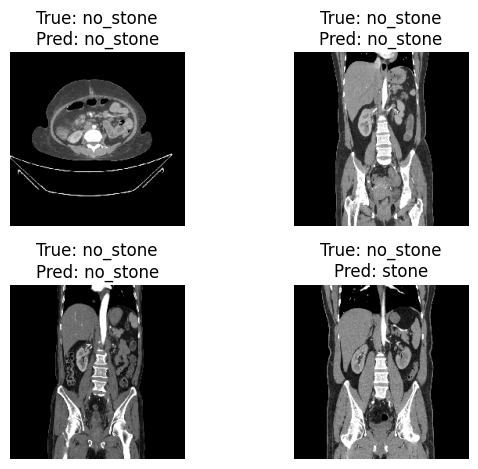

In [ ]:
import matplotlib.pyplot as plt

# Reset generator to start
test_generator.reset()
batch_x, batch_y = next(test_generator_rgb)

# Predict on batch
batch_pred = model.predict(batch_x)
batch_pred_classes = (batch_pred > 0.5).astype(int)

# Plot first 4 images
for i in range(min(4, len(batch_x))):
    plt.subplot(2, 2, i+1)
    plt.imshow(batch_x[i])
    plt.title(f"True: {'stone' if batch_y[i] == 1 else 'no_stone'}\nPred: {'stone' if batch_pred_classes[i] == 1 else 'no_stone'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files

# Upload a single image
uploaded = files.upload()  # Click "Choose Files" and select your image (e.g., test_image.jpg)
image_path = list(uploaded.keys())[0]  # Get the filename (e.g., 'test_image.jpg')

Saving Normal- (1609).jpg to Normal- (1609).jpg


In [ ]:
import tensorflow as tf
import numpy as np

def preprocess_image(image_path):
    # Load image
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(224, 224))
    # Convert to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Normalize to [0, 1]
    img_array = img_array / 255.0
    # Convert grayscale (224, 224, 1) to RGB (224, 224, 3)
    img_array_rgb = np.repeat(img_array, 3, axis=-1)
    # Add batch dimension (1, 224, 224, 3)
    img_array_rgb = np.expand_dims(img_array_rgb, axis=0)
    return img_array_rgb

# Preprocess the uploaded image
processed_image = preprocess_image(image_path)
print("Processed image shape:", processed_image.shape)  # Should be (1, 224, 224, 3)

Processed image shape: (1, 224, 224, 3)


In [ ]:
# Predict
prediction = model.predict(processed_image)
predicted_class = "Kidney Stone Detected" if prediction[0][0] > 0.5 else "No Kidney Stone"
confidence = prediction[0][0] * 100 if prediction[0][0] > 0.5 else (1 - prediction[0][0]) * 100

print(f"Prediction: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: No Kidney Stone
Confidence: 92.00%


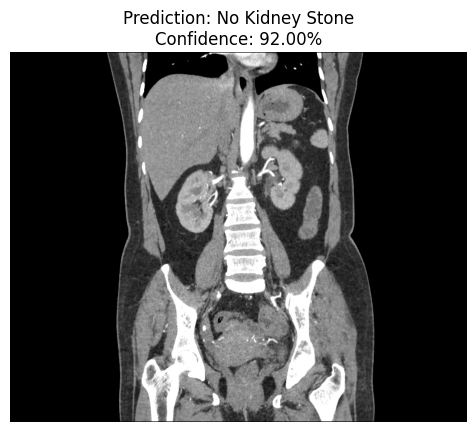

In [ ]:
import matplotlib.pyplot as plt

# Load original image for display (without preprocessing)
img_display = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale')
plt.imshow(img_display, cmap='gray')  # Use cmap='gray' for grayscale
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
plt.axis('off')
plt.show()

In [ ]:
# Save the model
model.save('/content/kidney_stone_model.h5')
print("Model saved to /content/kidney_stone_model.h5")

Model saved to /content/kidney_stone_model.h5


In [ ]:
# List files to confirm
!ls /content/

 dataset       kidney_stone_model.h5   sample_data
 dataset.zip  'Normal- (1609).jpg'    'Stone- (992).jpg'


In [ ]:
from google.colab import files

# Download the model
files.download('/content/kidney_stone_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>